In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC

from neupy.algorithms import PNN, GRNN

/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3

In [2]:
a1 = 0.2
b1 = 0.2
x0_1 = 0.25 # координаты параллельного переноса
y0_1 = -0.25
alpha1 = 0 # угол поворота

a2 = 0.7
b2 = 0.5
x0_2 = 0
y0_2 = 0
alpha2 = -np.pi/3

a3 = 1
b3 = 1
x0_3 = 0
y0_3 = 0
alpha3 = 0

In [3]:
t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025), endpoint=True)

In [4]:
def f(alpha, x0, a, t, y0, b):
    return (x0 + a * np.cos(t)) * np.cos(alpha) + (y0 + b * np.sin(t)) * np.sin(alpha)

def g(alpha, x0, a, t, y0, b):
    return -(x0 + a * np.cos(t)) * np.sin(alpha) + (y0 + b * np.sin(t)) * np.cos(alpha)

In [5]:
x1 = f(alpha1, x0_1, a1, t, y0_1, b1)
y1 = g(alpha1, x0_1, a1, t, y0_1, b1)

x2 = f(alpha2, x0_2, a2, t, y0_2, b2)
y2 = g(alpha2, x0_2, a2, t, y0_2, b2)

x3 = f(alpha3, x0_3, a3, t, y0_3, b3)
y3 = g(alpha3, x0_3, a3, t, y0_3, b3)

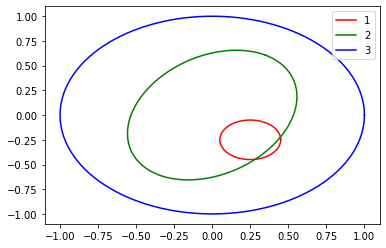

In [6]:
plt.plot(x1, y1, 'r', label='1')
plt.plot(x2, y2, 'g', label='2')
plt.plot(x3, y3, 'b', label='3')
plt.legend()

In [7]:
df1 = pd.DataFrame({'x' : x1, 'y' : y1, 'class' : 0})
df2 = pd.DataFrame({'x' : x2, 'y' : y2, 'class' : 1})
df3 = pd.DataFrame({'x' : x3, 'y' : y3, 'class' : 2})

Разделим выборку на тренировочную и тестовую  в соотношении 80% и 20% соответственно.

In [8]:
def Splitter(data):
    xTrain, xTest = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
    return xTrain, xTest

In [9]:
train, test = [], []

tmpTrain, tmpTest = Splitter(df1)
train.append(tmpTrain)
test.append(tmpTest)

tmpTrain, tmpTest = Splitter(df2)
train.append(tmpTrain)
test.append(tmpTest)

tmpTrain, tmpTest = Splitter(df3)
train.append(tmpTrain)
test.append(tmpTest)

train = pd.concat(train)
test = pd.concat(test)

Зададим область точек [-1.2, 1.2] x [-1.2, 1.2]. Получим сетку для указанной области с шагом h = 0.025.

In [10]:
def PointArea(model):
    h = 0.025
    # Точки области [-1.2, 1.2] x [-1.2, 1.2]
    x = np.arange(-1.2, 1.2 + h, h)
    y = np.arange(-1.2, 1.2 + h, h)

    xx, yy = np.meshgrid(x, y)

    # По уже обученной модели предскажем класс для каждой точки сетки.
    predictions = [model.predict(np.array([[i, j]])).round(1) for i in x for j in y]

    # Закодируем принадлежность к классам различными цветами
    colors = LabelBinarizer().fit_transform(np.asarray(predictions).flatten())

    plt.scatter(yy, xx, c=colors, cmap=plt.cm.winter);
    plt.show()

In [11]:
def TrainPredictShow(model, train, test):
    #Обучаем нейросеть
    model.fit(train.iloc[:, :-1], train['class'])
    
    p = []
    # Метрики обучения
    p.append(model.predict(train.iloc[:, :-1]))
    accTrain = accuracy_score(train['class'], p[-1])
    mseTrain = mean_squared_error(train['class'], p[-1])

    p.append(model.predict(test.iloc[:, :-1]))
    accTest = accuracy_score(test['class'], p[-1])
    mseTest = mean_squared_error(test['class'], p[-1])
    
    print('Train accuracy = {}'.format(accTrain))
    print(f'Train MSE = {mseTrain}')
    print(f'Train RMSE = {np.sqrt(mseTrain)}\n')
    
    # Построим график тренировочного множества
    plt.scatter(train['x'], train['y'], c=p[0], cmap=plt.cm.winter)
    plt.grid(True)
    plt.title('Train')
    plt.show()
    
    # Метрики обучения
    print('Test accuracy = {}'.format(accTest))
    print(f'Test MSE = {mseTest}')
    print(f'Test RMSE = {np.sqrt(mseTest)}\n')
    
    # Построим график тестового множества
    plt.scatter(test['x'], test['y'], c=p[1], cmap=plt.cm.winter)
    plt.grid(True)
    plt.title('Test')
    plt.show()
    
    # Классификация точек из области по заданию
    PointArea(model)

## Задание 1

Для трех линейно неразделимых классов решить задачу классификации.

Построим вероятностную сеть, которая будет классифицировать точки заданной области.

#### Param = 0.3

Train accuracy = 0.925
Train MSE = 0.075
Train RMSE = 0.27386127875258304



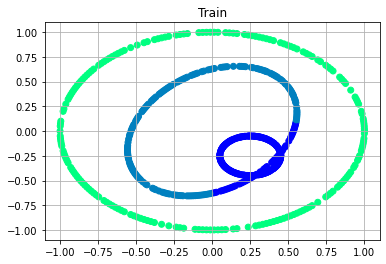

Test accuracy = 0.9281045751633987
Test MSE = 0.0718954248366013
Test RMSE = 0.2681332221799479



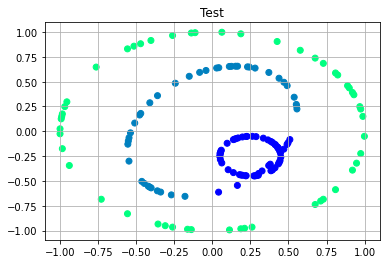

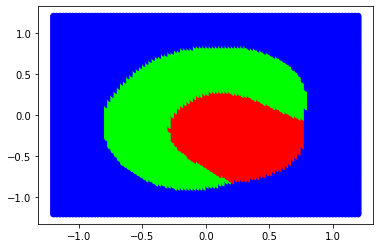

In [12]:
# PNN (Probabilistic Neural Network) - Вероятностная нейронная сеть
model1_03 = PNN(std=0.3)
TrainPredictShow(model1_03, train, test)

#### Param = 0.1

Train accuracy = 0.96
Train MSE = 0.04
Train RMSE = 0.2



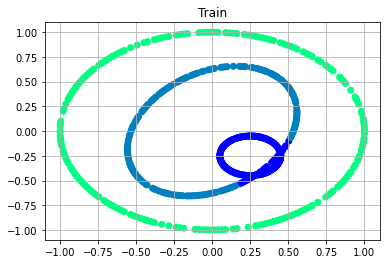

Test accuracy = 0.9477124183006536
Test MSE = 0.05228758169934641
Test RMSE = 0.2286647801900118



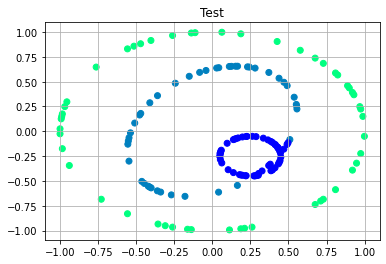

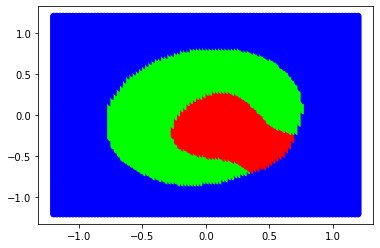

In [13]:
model1_01 = PNN(std=0.1)
TrainPredictShow(model1_01, train, test)

## Задание 2

Для трех линейно неразделимых классов решить задачу классификации.

Построим сеть с радиальными базисными элементами, которая будет классифицировать точки заданной области.

#### Param = 0.3

Train accuracy = 0.96
Train MSE = 0.04
Train RMSE = 0.2



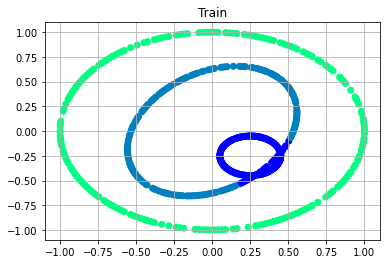

Test accuracy = 0.9477124183006536
Test MSE = 0.05228758169934641
Test RMSE = 0.2286647801900118



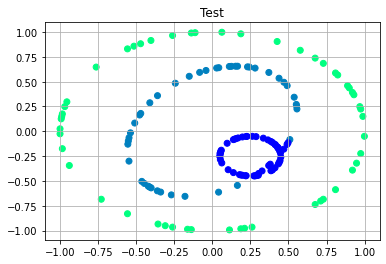

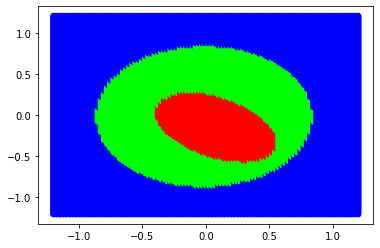

In [14]:
model2_03 = SVC(kernel='rbf', C=1e2, gamma=0.3)
TrainPredictShow(model2_03, train, test)

#### Param = 0.1

Train accuracy = 0.945
Train MSE = 0.055
Train RMSE = 0.2345207879911715



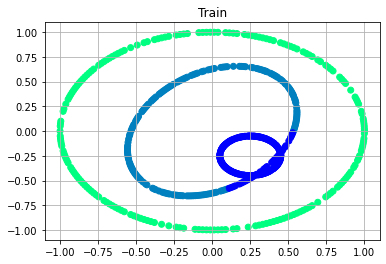

Test accuracy = 0.934640522875817
Test MSE = 0.06535947712418301
Test RMSE = 0.2556549962824568



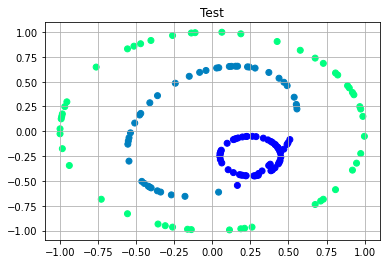

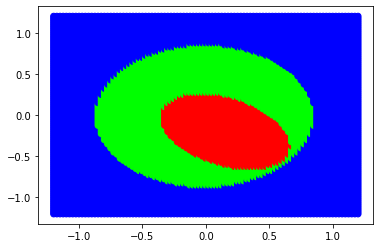

In [15]:
model2_01 = SVC(kernel='rbf', C=1e2, gamma=0.1)
TrainPredictShow(model2_01, train, test)

## Задание 3

Построить обобщенно-регрессионную нейронную сеть, которая будет выполнять аппроксимацию функции $sin(sin(t) * t^2 - t)$

In [16]:
def f(t):
    return np.sin(np.sin(t) * t**2 - t)

h = 0.01
t = np.linspace(1, 4.5, int(4.5 / h), endpoint=True)
x = f(t)

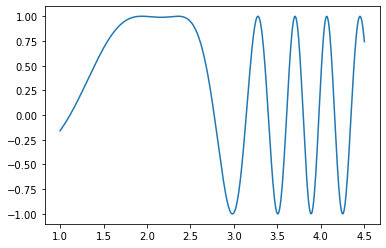

In [17]:
plt.plot(t, x)

In [18]:
def ScaleTrainPredictShow(model, xTrain, yTrain, xTest, yTest):
    # Нормализуем тестовые и тренировочные данные
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    scaledTrainX = scaler_x.fit_transform(xTrain[:, np.newaxis])
    scaledTestX = scaler_x.transform(xTest[:, np.newaxis])
    scaledTrainY = scaler_y.fit_transform(yTrain[:, np.newaxis])
    
    model.fit(scaledTrainX, scaledTrainY)
    
    xPredicted = model.predict(scaledTrainX)
    xPredicted = scaler_y.inverse_transform(xPredicted)

    # Ошибка обучения на тренировочном множестве
    mse = mean_squared_error(yTrain, xPredicted.flatten())
    print('Ошибка обучения на тренировочном множестве')
    print(f'MSE = {mse}')
    print(f'RMSE = {np.sqrt(mse)}')
    
    plt.scatter(xTrain, yTrain, label='Train')
    plt.scatter(xTrain, xPredicted, label='Predict')
    plt.legend()
    plt.show()
    
    # Получим апостериорную оценку качества работы сети:
    # проделаем аналогичные действия для тестового подмножества.
    xPredicted = model.predict(scaledTestX)
    xPredicted = scaler_y.inverse_transform(xPredicted)
    
    # Ошибка предсказания на тестовой выборке
    mse = mean_squared_error(yTest, xPredicted.flatten())
    print('Ошибка предсказания на тестовой выборке')
    print(f'MSE = {mse}')
    print(f'RMSE = {np.sqrt(mse)}')
    
    plt.scatter(xTest, yTest, label='Test')
    plt.scatter(xTest, xPredicted, label='Predict')
    plt.legend()
    plt.show()

Делим на тестовую и тренировочную выборку. Выделяем с конца временной последовательности 10% на тестовое подмножество.

In [19]:
percentTrain = 0.9
trainSize = int(len(t) * percentTrain)

xTrain = t[:trainSize]
yTrain = x[:trainSize]
xTest = t[trainSize:]
yTest = x[trainSize:]

Ошибка обучения на тренировочном множестве
MSE = 0.002870973299240921
RMSE = 0.053581464138645195


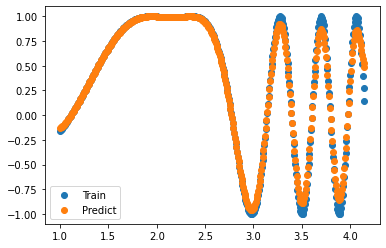

Ошибка предсказания на тестовой выборке
MSE = 0.6621886506197978
RMSE = 0.8137497469245676


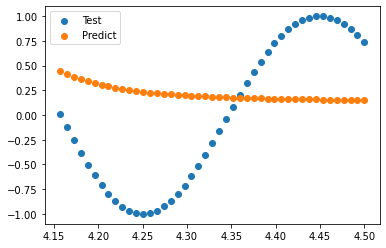

In [20]:
model3_h = GRNN(std=0.05)
ScaleTrainPredictShow(model3_h, xTrain, yTrain, xTest, yTest)

Разделим тренировочную и тестовую выборку в соотношении 80% и 20% соответственно.

In [21]:
xTrain, xTest, yTrain, yTest = train_test_split(t, x, train_size=0.8, shuffle=True, random_state=42)

Ошибка обучения на тренировочном множестве
MSE = 0.0009300371495825019
RMSE = 0.030496510449271107


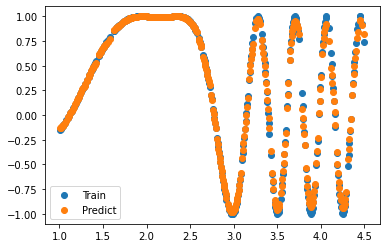

Ошибка предсказания на тестовой выборке
MSE = 0.0019145958988733027
RMSE = 0.04375609556248481


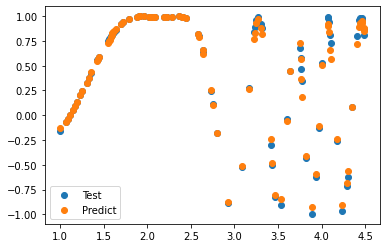

In [22]:
model3_h = GRNN(std=0.03)
ScaleTrainPredictShow(model3_h, xTrain, yTrain, xTest, yTest)